In [10]:
#import libraries and functions to load the data
from matplotlib import pyplot as plt

import os
import time

import numpy as np
import torch
import torch.nn.functional as F

In [11]:
#for nvidia 
has_gpu = torch.cuda.is_available()
#for mac
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

## Some Hyperparameters 
random_seed = 1
batch_size = 32
learning_rate = 0.001
num_epochs = 30
num_classes = 12

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


/var/folders/18/jb6sg5tn0wd0md220_4vpttw0000gn/T/ipykernel_26019/3388286980.py:4: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  has_mps = getattr(torch,'has_mps',False)
/var/folders/18/jb6sg5tn0wd0md220_4vpttw0000gn/T/ipykernel_26019/3388286980.py:5: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch,'has_mps',False) \


In [12]:
from torchvision import transforms, datasets
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

train_data_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((32, 32)),  
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)
test_data_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((32, 32)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

In [13]:
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split
from torchvision.datasets import FashionMNIST
import torchvision
import torch
from torch.utils.data import DataLoader, Dataset, random_split


dataset = torchvision.datasets.ImageFolder(root='kanji_dataset', transform=train_data_transform)

train_size = int(0.8 * len(dataset))  
test_size = len(dataset) - train_size  
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_size = int(0.9 * len(train_dataset))  
valid_size = len(train_dataset) - train_size  

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Mini_batch Dimensions: [B, C, H, W] = 
torch.Size([32, 1, 32, 32])


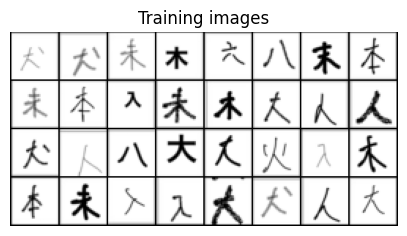

Labels = 
[[ 6  6  8  7]
 [ 9  1 10  5]
 [ 8  5  2  8]
 [ 7  0  4  4]
 [ 6  4  1  0]
 [ 0  3  2  7]
 [ 5  8  2  2]
 [ 0  6  4  0]]


In [14]:
import torchvision.utils as vutils

%matplotlib inline
import matplotlib.pyplot as plt

im_batch = next(iter(train_loader))
print('Mini_batch Dimensions: [B, C, H, W] = ')
print(im_batch[0].shape)
plt.figure(figsize=(5, 5))
plt.title("Training images")
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(im_batch[0][:64], nrow=8, padding=1, normalize=True), (1, 2, 0)
    )
)
plt.show()
print("Labels = " )
print(im_batch[1][:64].data.numpy().reshape(8,-1))


In [15]:
import torch
import torchvision.models as models

vgg16 = models.vgg16(pretrained=False)

print(vgg16)

final_layer = vgg16.classifier[6]

num_classes = 4
vgg16.classifier[6] = torch.nn.Linear(final_layer.in_features, num_classes)

print(vgg16.classifier)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        model = model.train()
        true_pred = 0
        tot_samples = 0
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            _, label_pred = torch.max(logits, axis=1)
            true_pred += (label_pred==labels).sum()
            tot_samples += labels.shape[0]
        acc = (true_pred/float(tot_samples))*100
    return acc

Epoch [1/10], Train Loss: 3210341914.8688, Valid Loss: 2.5797, Train Accuracy: 7.08%, Valid Accuracy: 10.06%, Time: 1.33 min, Learning Rate 0.01000000 -> 0.00500000
Epoch [2/10], Train Loss: 2.5780, Valid Loss: 2.4916, Train Accuracy: 7.57%, Valid Accuracy: 7.14%, Time: 2.85 min, Learning Rate 0.00500000 -> 0.00250000
Epoch [3/10], Train Loss: 2.4926, Valid Loss: 2.4940, Train Accuracy: 7.41%, Valid Accuracy: 5.52%, Time: 4.29 min, Learning Rate 0.00250000 -> 0.00125000
Epoch [4/10], Train Loss: 2.4890, Valid Loss: 2.4931, Train Accuracy: 6.84%, Valid Accuracy: 5.52%, Time: 9.40 min, Learning Rate 0.00125000 -> 0.00062500
Epoch [5/10], Train Loss: 2.4861, Valid Loss: 2.4929, Train Accuracy: 9.61%, Valid Accuracy: 5.52%, Time: 10.94 min, Learning Rate 0.00062500 -> 0.00031250
Epoch [6/10], Train Loss: 2.4851, Valid Loss: 2.4927, Train Accuracy: 8.63%, Valid Accuracy: 5.52%, Time: 12.39 min, Learning Rate 0.00031250 -> 0.00015625
Epoch [7/10], Train Loss: 2.4852, Valid Loss: 2.4926, Trai

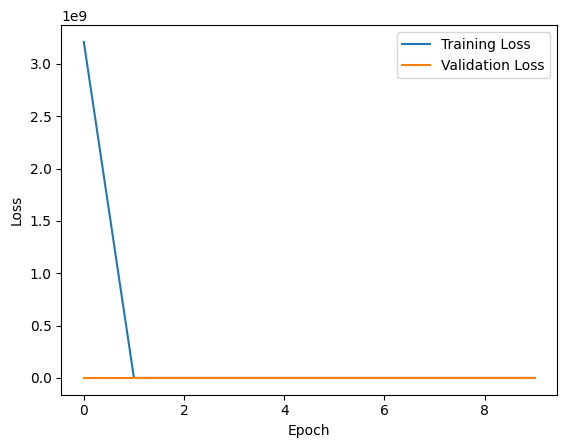

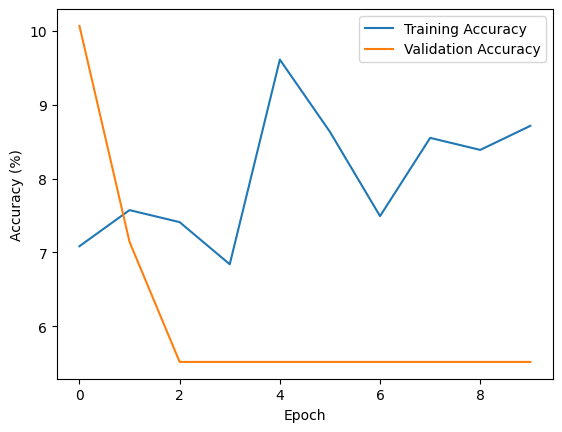

In [18]:
import torch
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import time
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16 = models.vgg16(pretrained=False)

weights = vgg16.features[0].weight.data

new_weights = weights[:, 0, :, :].unsqueeze(1)

vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
vgg16.features[0].weight.data = new_weights

final_layer = vgg16.classifier[6]
num_classes = 12
vgg16.classifier[6] = torch.nn.Linear(final_layer.in_features, num_classes)

vgg16 = vgg16.to(device)

optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

def train(model, optimizer, scheduler, train_loader, valid_loader, device, num_epochs=30):
    start = time.time()
    train_costs = []
    valid_costs = []
    train_accuracies = []  
    valid_accuracies = []  
    for epoch in range(num_epochs):
        model.train()
        sum_loss = 0.0
        correct_train = 0
        total_train = 0
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            
            _, predicted_train = torch.max(logits, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
        
        train_costs.append(sum_loss / len(train_loader))
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        prev_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        current_lr = optimizer.param_groups[0]["lr"]

        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for imgs, labels in valid_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                logits = model(imgs)
                valid_loss += F.cross_entropy(logits, labels, reduction='sum').item()
                
                # テストデータセットでの正確さを計算
                _, predicted_valid = torch.max(logits, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted_valid == labels).sum().item()
        valid_costs.append(valid_loss / len(valid_loader.dataset))
        valid_accuracy = 100 * correct_valid / total_valid
        valid_accuracies.append(valid_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_costs[-1]:.4f}, "
              f"Valid Loss: {valid_costs[-1]:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Valid Accuracy: {valid_accuracy:.2f}%, "
              f"Time: {(time.time() - start) / 60:.2f} min, "
              f"Learning Rate {prev_lr:.8f} -> {current_lr:.8f}")

    print(f"Total Training Time: {(time.time() - start) / 60:.2f} min")

    plt.plot(range(len(train_costs)), train_costs, label='Training Loss')
    plt.plot(range(len(valid_costs)), valid_costs, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(valid_accuracies)), valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

train(vgg16, optimizer, scheduler, train_loader, valid_loader, device, num_epochs=10)
